# Reduced-rank regression analysis

In [1]:
# Prepare

%matplotlib notebook

import numpy as np
import pylab as plt
import seaborn as sns; sns.set()
import pandas as pd
import matplotlib
import pickle
import scipy
import time
import warnings

import rnaseqTools

# pip install glmnet_py
import sparseRRR

def sns_styleset():
    sns.set(context='paper', style='ticks', font='Arial')
    matplotlib.rcParams['axes.linewidth']    = .5
    matplotlib.rcParams['xtick.major.width'] = .5
    matplotlib.rcParams['ytick.major.width'] = .5
    matplotlib.rcParams['xtick.major.size'] = 2
    matplotlib.rcParams['ytick.major.size'] = 2
    matplotlib.rcParams['xtick.minor.size'] = 1
    matplotlib.rcParams['ytick.minor.size'] = 1
    matplotlib.rcParams['font.size']       = 6
    matplotlib.rcParams['axes.titlesize']  = 6
    matplotlib.rcParams['axes.labelsize']  = 6
    matplotlib.rcParams['legend.fontsize'] = 6
    matplotlib.rcParams['xtick.labelsize'] = 6
    matplotlib.rcParams['ytick.labelsize'] = 6
    matplotlib.rcParams['figure.dpi'] = 120

sns_styleset()

In [2]:
from collections import namedtuple
cnData = namedtuple('cnData', 'exonCounts cells genes cre mapping_rate\
                                         seq_depth recording tenx_cluster \
                                         patchseq_cluster expert_label gene_counts\
                                         ephys ephysNames \
                                         morphometrics morphometricsNames\
                                         cellcolor')



cn = pickle.load(open('../cn.pickle', 'rb'))



clusterColors = cn.cellcolor
clusterNames = cn.expert_label
clusterN = clusterNames.size

In [3]:
features_exclude = ['Holding (pA)', 'Step Increase (pA)',
       'First Current Injection (pA)','AP2_Diff', 'AP3_Diff',
       'AP_End_Diff', 'Rebound_abs (mV)', 'Rebound_spikes',
       'epsc_rise_time (ms)','epsc_half_width (ms)', 'epsc_decay_tau (ms)', 'epsc_freq (Hz)',
       'epsc_amp (pA)', 'ipsc_rise_time (ms)', 'ipsc_half_width (ms)','Spike_Delay @ 2xRheobase',
       'ipsc_decay_tau (ms)', 'ipsc_freq (Hz)', 'ipsc_amp (pA)','AP Number @ 2xRheabase',]

ephysY = cn.ephys.copy()
ephysY = ephysY[:, ~np.isin(cn.ephysNames, features_exclude)]
print(ephysY.shape)

(438, 16)


Chosen offset: 7.39


<IPython.core.display.Javascript object>


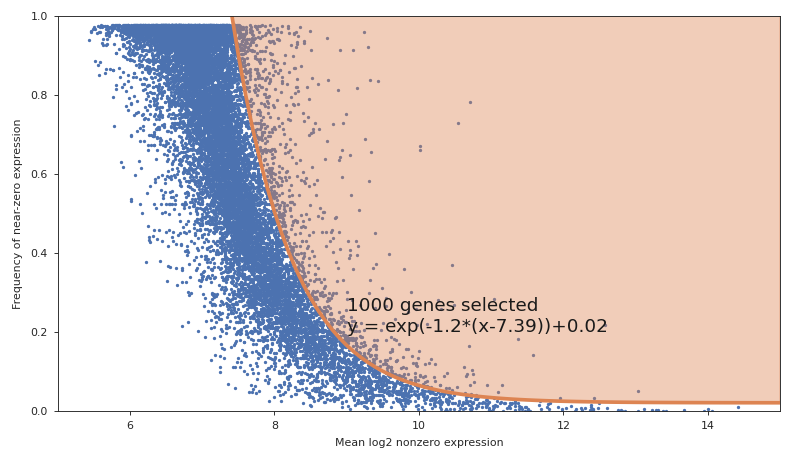

findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.


In [6]:
genesForRRR  = rnaseqTools.geneSelection(cn.exonCounts, n=1000, threshold=32, decay=1.2)

In [7]:
X =  cn.exonCounts#[selection,:] / m1.exonLengths
#X += m1.intronCounts[selection,:] / (m1.intronLengths + 0.001)
X /= np.sum(X, axis=1)
X *= 1e+6
X = X[:, genesForRRR]

X = np.array(X)
X = np.log2(X + 1)
X = X - np.mean(X, axis=0)
X = X / np.std(X, axis=0)

Y = ephysY - np.mean(ephysY, axis=0)
Y = Y / np.std(Y, axis=0)

print('Shape of X:', X.shape, '\nShape of Y:', Y.shape)

Shape of X: (438, 1000) 
Shape of Y: (438, 16)


In [8]:
w,v = sparseRRR.relaxed_elastic_rrr(X, Y, rank=5, lambdau=.5, alpha=1)

print(cn.genes[genesForRRR][np.where(w[:,0]!=0)[0]])
print(np.sum(w[:,0]!=0))

['Cryba2' 'Rgs4' 'Ass1' 'Gad1' 'Lamp5' 'Mafb' 'Ptprt' 'Phgdh' 'Cnpy1'
 'Lgi2' 'Spp1' 'Cit' 'Tmem132c' 'Dkk3' 'Cx3cl1' 'Calb2' 'Rasgrf1' 'Stac'
 'Utrn' 'Kcnc2' 'Il22' 'Efemp1' 'Nefm' 'Cdh12' 'Fgf13']
25


In [9]:
shortEphysLabels = {'Tau (ms)': 'Tau',
                    'SagRatio': 'Sag',
                    'Rebound (mV)': 'Rebound',
                    'RM (Mohm)': 'RM',
                    'RMP (mV)': 'RMP',
                    'RheoBase (pA)': 'Rheobase',
                    'Spike Delay (ms)': 'Spike_Delay',
                    'Threshold (mV)': 'Threshold',
                    'Amplitude (mV)': 'Amp',
                    'AHP (mV)': 'AHP',
                    'Depolarization Time (ms)': 'Depo time',
                    'Repolarization Time (ms)': 'Repo time',
                    'Half Width (ms)': 'Half Width',
                    'Max Spike Number': 'Max spike N',
                    'Initial Adaptation': 'Initial Adapt',
                    'Last Adaptation': 'Last Adapt'}

In [10]:
def adjustlabels(fig, labels, max_iter=1000, eps=0.01, delta=0.1, 
                 clip_to_axes=True, pad=0.1):
    N = len(labels)
    widths = np.zeros(N)
    heights = np.zeros(N)
    centers = np.zeros((N, 2))
    for i,l in enumerate(labels):
        bb = l.get_window_extent(renderer=fig.canvas.get_renderer())
        bb = bb.transformed(plt.gca().transData.inverted())
        widths[i] = bb.width
        heights[i] = bb.height
        centers[i] = (bb.min + bb.max)/2
        
    ylim = plt.gca().get_ylim()
    xlim = plt.gca().get_xlim()    

    def clip():
        for i in range(N):
            centers[i,0] = max(centers[i,0], xlim[0] + widths[i]/2 + pad)
            centers[i,0] = min(centers[i,0], xlim[1] - widths[i]/2 - pad)
            centers[i,1] = max(centers[i,1], ylim[0] + heights[i]/2 + pad)
            centers[i,1] = min(centers[i,1], ylim[1] - heights[i]/2 - pad)
            labels[i].set_position(centers[i])
    clip()

    for i in range(max_iter):
        stop = True
        for a in range(N):
            for b in range(N):
                if ((a!=b) and
                    (np.abs(centers[a,0]-centers[b,0]) < (widths[a]+widths[b])/2 + delta) and
                    (np.abs(centers[a,1]-centers[b,1]) < (heights[a]+heights[b])/2 +  delta)):
                    
                    d = centers[a] - centers[b]
                    centers[a] += d * eps
                    centers[b] -= d * eps
                    labels[a].set_position(centers[a])
                    labels[b].set_position(centers[b])
                    if clip_to_axes:
                        clip()
                    stop = False
        if stop:
            break    

<IPython.core.display.Javascript object>


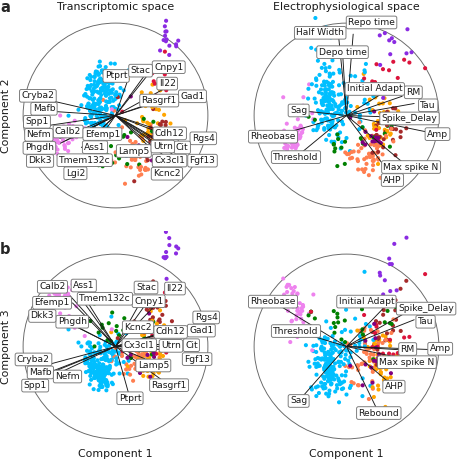

findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.


In [11]:
fig = plt.figure(figsize=(3.5, 3.5))

L = 3.75
scaleFactor = 3
s = 5
width = .5
col = clusterColors
labelslabels = [cn.genes[genesForRRR], 
                [shortEphysLabels[e] for e in cn.ephysNames if e not in features_exclude]]

for row, components in enumerate([[0,1], [0,2]]):

    Zx = X @ w[:,components]
    Zy = Y @ v[:,components]
    Zx = Zx / np.std(Zx, axis=0)
    Zy = Zy / np.std(Zy, axis=0)

    for column, (Z,F,wv,labels) in enumerate(zip([Zx,Zy], [X,Y], [w,v],labelslabels)):
    
        plt.axes([column*width+(1-2*width)/2, .5-row*width, width, width])
        plt.scatter(Z[:,0], Z[:,1], c=col,s=s, edgecolors='none')
        plt.xticks([])
        plt.yticks([])
        plt.xlim([-L,L])
        plt.ylim([-L,L])
        Rho = np.corrcoef(np.concatenate((Z[:,:2], F), axis=1), rowvar=False)[2:,:2]
        shownlabels = []
        for i in np.where(wv[:,0]!=0)[0]:
            if np.sqrt(np.sum(Rho[i,:]**2)) > .4:
                plt.plot([0, scaleFactor*Rho[i,0]], [0, scaleFactor*Rho[i,1]], 
                         linewidth=.5, color='k', zorder=1)
                l = plt.text(scaleFactor*Rho[i,0]*1.1, scaleFactor*Rho[i,1]*1.1, labels[i],
                     ha='center', va='center', color='k', fontsize=5, zorder=10,
                     bbox=dict(facecolor='w', edgecolor='#777777', boxstyle='round', linewidth=.5, pad=.2))
                shownlabels.append(l)
        
        adjustlabels(fig, shownlabels)
        circ = plt.Circle((0,0), radius=scaleFactor, color=[.4, .4, .4], fill=False, linewidth=.5, zorder=-1)
        plt.gca().add_patch(circ)

plt.gcf().text((1-2*width)/2+width/2, .978, 'Transcriptomic space', ha='center', fontsize=6, color='k')
plt.gcf().text(.5+width/2, .978, 'Electrophysiological space', ha='center', fontsize=6, color='k')
plt.gcf().text((1-2*width)/2+width/2, .01, 'Component 1', ha='center', fontsize=6, color='k')
plt.gcf().text(.5+width/2, .01, 'Component 1', ha='center', fontsize=6, color='k')
plt.gcf().text(.002, .5+width/2, 'Component 2', va='center', fontsize=6, color='k', rotation=90)
plt.gcf().text(.002, (1-2*width)/2+width/2, 'Component 3', va='center', fontsize=6, color='k', rotation=90)

fig.text(0,  1,  'a', fontsize=8, fontweight='bold', va='top')
fig.text(0, .45,  'b', fontsize=8, fontweight='bold')
        
sns.despine(left=True, bottom=True)

plt.savefig('rrr.pdf', dpi=300)
plt.savefig('rrr.pdf')

## Boostrap gene selection

In [12]:
%%time

w,v = sparseRRR.relaxed_elastic_rrr(X, Y, rank=5, lambdau=.5, alpha=1)

bootCounts = sparseRRR.elastic_rrr_bootstrap(X, Y, rank=5, lambdau=.5, alpha=1, nrep=100)

.................................................................................................... 
CPU times: user 6min 53s, sys: 28min 43s, total: 35min 37s
Wall time: 34.5 s


In [13]:
args = np.argsort(bootCounts)[::-1]
for i in range(25):
    print('{:10} {:.2f}'.format(cn.genes[genesForRRR][args[i]],
                                bootCounts[args[i]]), end='')
    if ~np.isclose(w[args[i],0],0):
        print('  *')
    else:
        print('')

Cryba2     1.00  *
Kcnc2      1.00  *
Calb2      1.00  *
Spp1       0.95  *
Fgf13      0.92  *
Tmem132c   0.87  *
Lgi2       0.87  *
Ptprt      0.83  *
Ass1       0.76  *
Stac       0.76  *
Utrn       0.76  *
Cx3cl1     0.73  *
Rasgrf1    0.72  *
Il22       0.72  *
Dkk3       0.70  *
Cit        0.65  *
Lamp5      0.64  *
Gad1       0.57  *
Cnpy1      0.46  *
Phgdh      0.45  *
Rgs4       0.44  *
Efemp1     0.44  *
Ndnf       0.42
Nefm       0.41  *
Cdh12      0.40  *


## Cross-validation

In [14]:
lambdas = np.array([.45])
alphas = np.array([1])

r2, r2_relaxed, nonzero, corrs, corrs_relaxed = sparseRRR.elastic_rrr_cv(
    X, Y, rank=5, reps=1, folds=10, alphas=alphas, lambdas=lambdas)

print('R2: {:.2f}, corrs: {:.2f}, {:.2f}, {:.2f}, {:.2f}, {:.2f}'.format(
    np.mean(r2_relaxed), *np.mean(corrs_relaxed,axis=0).squeeze()))

1.......... Time: 0.0h  0m  7s
R2: 0.35, corrs: 0.87, 0.69, 0.76, 0.60, 0.36


In [15]:
%%time

lambdas = np.concatenate((np.arange(.2,1.01,.1), np.arange(2,7)))
alphas = np.array([.5, .75, 1])

cvresults = sparseRRR.elastic_rrr_cv(X, Y, rank=5, reps=1, folds=10, alphas=alphas, lambdas=lambdas)

lambdas = np.arange(.2,1,.1)
alphas = np.array([1])
ranks = np.arange(1, Y.shape[1]+1)

cvresults_rank = {}
for r in ranks:
    cvresults_rank[r] = sparseRRR.elastic_rrr_cv(X, Y, rank=r, reps=1, folds=10, alphas=alphas, lambdas=lambdas)
    
pickle.dump([cvresults, cvresults_rank], open('cvresults.pickle', 'wb'))

1.......... Time: 0.0h  7m  8s
1.......... Time: 0.0h  0m 10s
1.......... Time: 0.0h  0m 29s
1.......... Time: 0.0h  0m 21s
1.......... Time: 0.0h  0m 39s
1.......... Time: 0.0h  1m 25s
1.......... Time: 0.0h  0m 54s
1.......... Time: 0.0h  0m 50s
1.......... Time: 0.0h  1m 33s
1.......... Time: 0.0h  1m 51s
1.......... Time: 0.0h  1m 55s
1.......... Time: 0.0h  1m  3s
1.......... Time: 0.0h  1m 30s
1.......... Time: 0.0h  1m 12s
1.......... Time: 0.0h  1m  5s
1.......... Time: 0.0h  0m 36s
1.......... Time: 0.0h  0m 22s
CPU times: user 2h 30min 13s, sys: 10h 51min 17s, total: 13h 21min 31s
Wall time: 23min 3s


<IPython.core.display.Javascript object>


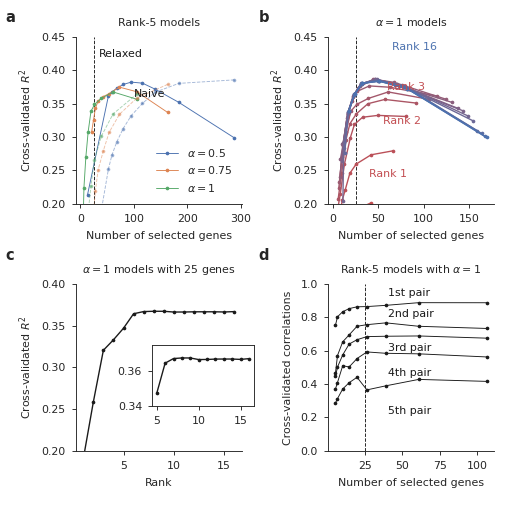

In [16]:
cvresults, cvresults_rank = pickle.load(open('cvresults.pickle', 'rb'))

r2, r2_relaxed, nonzeros, corrs, corrs_relaxed = cvresults
with warnings.catch_warnings():
    warnings.simplefilter('ignore', category=RuntimeWarning)
    nonzeros = np.nanmean(nonzeros, axis=(0,1))
    r2_relaxed = np.nanmean(r2_relaxed, axis=(0,1))
    r2 = np.nanmean(r2, axis=(0,1))
    corrs_relaxed = np.nanmean(corrs_relaxed, axis=(0,1))

fig = plt.figure(figsize=(3.5, 3.5))
plt.subplot(221)
plt.plot(nonzeros, r2_relaxed, '.-', linewidth=.5, markersize=2)
plt.gca().set_prop_cycle(None)
plt.plot(nonzeros, r2, '.--', linewidth=.5, alpha=.5, markersize=2)
plt.xlabel('Number of selected genes')
plt.ylabel('Cross-validated $R^2$')
plt.ylim([.2,.45])
plt.legend(['$\\alpha='+str(a)+'$' for a in [.5, .75, 1]], frameon=False)
plt.plot([25,25],[.2,.45],'k--', linewidth=.5, zorder=0)
plt.title('Rank-5 models')
plt.text(100, .36, 'Naive', color='k', fontsize=6)
plt.text(35, .42, 'Relaxed', color='k', fontsize=6)

plt.subplot(224)
for k in range(corrs_relaxed.shape[2]):
    plt.plot(nonzeros[:,2], corrs_relaxed[:,2,k].squeeze(), 'k.-', linewidth=.5, markersize=2)
plt.xlabel('Number of selected genes')
plt.ylabel('Cross-validated correlations')
plt.ylim([0,1])
plt.title(r'Rank-5 models with $\alpha=1$')
plt.plot([25,25],[0,1],'k--', linewidth=.5, zorder=0)
for i,c in zip(['1st','2nd','3rd','4th','5th'], [.93,.8,.6,.45,.22]):
    plt.text(40, c, '{} pair'.format(i), color='k', fontsize=6)

plt.subplot(222)
maxRank = len(cvresults_rank)
colA = np.array([76, 114, 176]) / 256
colB = np.array([196, 78, 82])  / 256
perf25 = np.zeros(maxRank+1)
for rank in range(1,maxRank+1):
    with warnings.catch_warnings():
        warnings.simplefilter('ignore', category=RuntimeWarning)
        n = np.nanmean(cvresults_rank[rank][2], axis=(0,1))
        c = np.nanmean(cvresults_rank[rank][0], axis=(0,1))
        cr = np.nanmean(cvresults_rank[rank][1], axis=(0,1))
        f = scipy.interpolate.interp1d(n.squeeze(), cr.squeeze(), kind='linear')
        perf25[rank] = f(25)
    col = (colA * (rank-1)/(maxRank-1) + colB * (maxRank-rank)/(maxRank-1))
    plt.plot(n[:,0], cr[:,0], '.-', color=col, linewidth=.75, markersize=2)
plt.ylim([.2,.45])
plt.xlabel('Number of selected genes')
plt.ylabel('Cross-validated $R^2$')
plt.plot([25,25],[.2,.45],'k--', linewidth=.5, zorder=0)
plt.text(40, .24, 'Rank 1', color=colB, fontsize=6)
plt.text(55, .32, 'Rank 2', color=colB, fontsize=6)
plt.text(60, .37, 'Rank 3', color=colB, fontsize=6)
plt.text(65, .43, 'Rank 16', color=colA, fontsize=6)
plt.title(r'$\alpha=1$ models')

plt.subplot(223)
plt.plot(np.arange(1,maxRank+1), perf25[1:], 'k.-', linewidth=.75, markersize=2)
plt.xlabel('Rank')
plt.ylabel('Cross-validated $R^2$')
plt.ylim([.2,.4])
plt.title(r'$\alpha=1$ models with 25 genes')

sns.despine()
plt.tight_layout()

ax = plt.axes([.3,.2,.2,.12])
plt.plot(np.arange(5,maxRank+1), perf25[5:], 'k.-', linewidth=.75, markersize=2)
plt.ylim([0.34,0.375])

fig.text(.01, .98,  'a', fontsize=8, fontweight='bold', va='top')
fig.text(.51, .98,  'b', fontsize=8, fontweight='bold', va='top')
fig.text(.01, .51,  'c', fontsize=8, fontweight='bold', va='top')
fig.text(.51, .51,  'd', fontsize=8, fontweight='bold', va='top')

plt.savefig('rrr-cv.pdf', dpi=300)

# Ion channel genes only

In [17]:
import pandas as pd
ionchannelgenes = pd.read_csv('ion_channel_GPCR_geneset.csv')['Approved symbol'].values
print(ionchannelgenes.size)

#selection = ~np.isnan(np.sum(ephysY, axis=1)) & (cn.exclude=='') & (ttypes['type']!='')

genesForRRR = np.array([m.upper() in ionchannelgenes for m in cn.genes]) & \
              np.array((np.sum(cn.exonCounts>0,axis=0)>=10)).squeeze()

X =  cn.exonCounts#[selection,:] / cn.exonLengths
#X += cn.intronCounts[selection,:] / (cn.intronLengths + 0.001)
X /= np.sum(X, axis=1)
X *= 1e+6
X = X[:, genesForRRR]

X = np.array(X)
X = np.log2(X + 1)
X = X - np.mean(X, axis=0)
X = X / np.std(X, axis=0)




Y = ephysY - np.mean(ephysY, axis=0)
Y = Y / np.std(Y, axis=0)

print('Shape of X:', X.shape, '\nShape of Y:', Y.shape)

1745
Shape of X: (438, 477) 
Shape of Y: (438, 16)


In [18]:
w,v = sparseRRR.relaxed_elastic_rrr(X, Y, rank=5, lambdau=.303, alpha=1)

print(cn.genes[genesForRRR][np.where(w[:,0]!=0)[0]])
print(np.sum(w[:,0]!=0))

['Kcnb2' 'Adora1' 'Kcnh7' 'Ryr3' 'Hrh3' 'Kcnq4' 'Gabrd' 'Drd5' 'Gabrg1'
 'Gabrb1' 'Fzd9' 'Gpr12' 'Kcnd2' 'Grm8' 'Grid2' 'Itpr1' 'Grm7' 'Kcna6'
 'Grin2b' 'Ryr1' 'Kcnc3' 'Gabra5' 'Ano1' 'Glra3' 'Scn3b' 'Scn4b' 'Grm1'
 'Ano4' 'Kcnc2' 'Gabra1' 'Glra1' 'Asic2' 'Cacng5' 'Kcnh5' 'Chrm3'
 'Cacna2d3' 'Nalcn' 'Grin2a' 'Fshr' 'Adrb1' 'Gria3' 'Trpc5']
42


In [19]:
lambdas = np.array([.303])
alphas = np.array([1])
r2, r2_relaxed, nonzero, corrs, corrs_relaxed = sparseRRR.elastic_rrr_cv(
    X, Y, rank=5, reps=1, folds=10, alphas=alphas, lambdas=lambdas)

print('R2: {:.2f}, corrs: {:.2f}, {:.2f}, {:.2f}, {:.2f}, {:.2f}'.format(
    np.mean(r2_relaxed), *np.mean(corrs_relaxed,axis=0).squeeze()))

1.......... Time: 0.0h  0m  3s
R2: 0.33, corrs: 0.84, 0.66, 0.70, 0.62, 0.41


In [20]:
L = 3.75
scaleFactor = 3
s = 5
width = .5
col = clusterColors

<IPython.core.display.Javascript object>


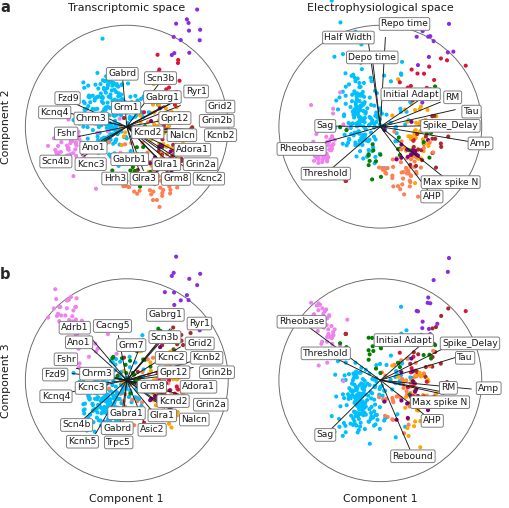

In [21]:
fig = plt.figure(figsize=(3.5, 3.5))

L = 3.75
scaleFactor = 3
s = 5
width = .5
col = clusterColors
labelslabels = [cn.genes[genesForRRR], 
                [shortEphysLabels[e] for e in cn.ephysNames if e not in features_exclude]]
offsets = [[{},{}],[{},{}]]

for row, components in enumerate([[0,1], [0,2]]):

    Zx = X @ w[:,components]
    Zy = Y @ v[:,components]
    Zx = Zx / np.std(Zx, axis=0)
    Zy = Zy / np.std(Zy, axis=0)

    for column, (Z,F,wv,labels) in enumerate(zip([Zx,Zy], [X,Y], [w,v], labelslabels)):
    
        plt.axes([column*width+(1-2*width)/2, .5-row*width, width, width])
        plt.scatter(Z[:,0], Z[:,1], c=col, s=s, edgecolors='none')
        plt.xticks([])
        plt.yticks([])
        plt.xlim([-L,L])
        plt.ylim([-L,L])
        shownlabels = []
        Rho = np.corrcoef(np.concatenate((Z[:,:2], F), axis=1), rowvar=False)[2:,:2]
        for i in np.where(wv[:,0]!=0)[0]:
            if np.sqrt(np.sum(Rho[i,:]**2)) > .4:
                plt.plot([0, scaleFactor*Rho[i,0]], [0, scaleFactor*Rho[i,1]], 
                         linewidth=.5, color='k', zorder=1)
                dx,dy = 0,0
                if labels[i] in offsets[row][column]:
                    dx += offsets[row][column][labels[i]][0]
                    dy += offsets[row][column][labels[i]][1]
                l = plt.text(scaleFactor*Rho[i,0]*1.1 + dx, scaleFactor*Rho[i,1]*1.1 + dy, labels[i],
                     ha='center', va='center', color='k', fontsize=5, zorder=10,
                     bbox=dict(facecolor='w', edgecolor='#777777', boxstyle='round', linewidth=.5, pad=.2))
                shownlabels.append(l)

        adjustlabels(fig, shownlabels)
        circ = plt.Circle((0,0), radius=scaleFactor, color=[.4, .4, .4], fill=False, linewidth=.5, zorder=-1)
        plt.gca().add_patch(circ)

plt.gcf().text((1-2*width)/2+width/2, .978, 'Transcriptomic space', ha='center', fontsize=6, color='k')
plt.gcf().text(.5+width/2, .978, 'Electrophysiological space', ha='center', fontsize=6, color='k')
plt.gcf().text((1-2*width)/2+width/2, .01, 'Component 1', ha='center', fontsize=6, color='k')
plt.gcf().text(.5+width/2, .01, 'Component 1', ha='center', fontsize=6, color='k')
plt.gcf().text(.002, .5+width/2, 'Component 2', va='center', fontsize=6, color='k', rotation=90)
plt.gcf().text(.002, (1-2*width)/2+width/2, 'Component 3', va='center', fontsize=6, color='k', rotation=90)

fig.text(0,  1,  'a', fontsize=8, fontweight='bold', va='top')
fig.text(0, .45,  'b', fontsize=8, fontweight='bold')
        
sns.despine(left=True, bottom=True)

plt.savefig('rrr-ionchannels.png', dpi=300)
plt.savefig('rrr-ionchannels.pdf', dpi=300)

In [67]:
morphY = cn.morphometrics.copy()
selection = ~np.isnan(cn.morphometrics)[:,0]
print(np.sum(selection))
morphY = morphY[selection,:]
genesForRRR  = rnaseqTools.geneSelection(cn.exonCounts[selection,:], n=1000, threshold=32, decay=1.5, plot=False)

170
Chosen offset: 7.51


In [99]:
X =  cn.exonCounts[selection,:]# / m1.exonLengths
#X += m1.intronCounts[selection,:] / (m1.intronLengths + 0.001)
X /= np.sum(X, axis=1)
X *= 1e+6
X = X[:, genesForRRR]

X = np.array(X)
X = np.log2(X + 1)
X = X - np.mean(X, axis=0)
X = X / np.std(X, axis=0)

Y = morphY - np.mean(morphY, axis=0)
Y = Y / np.std(Y, axis=0)
Y = np.nan_to_num(Y)
print('Shape of X:', X.shape, '\nShape of Y:', Y.shape)

Shape of X: (170, 1000) 
Shape of Y: (170, 45)


/opt/tljh/user/lib/python3.7/site-packages/ipykernel_launcher.py:13: RuntimeWarning: invalid value encountered in true_divide
  del sys.path[0]


In [137]:
w,v = sparseRRR.relaxed_elastic_rrr(X, Y, rank=5, lambdau=.83, alpha=1)
print(cn.genes[genesForRRR][np.where(w[:,0]!=0)[0]])
print(np.sum(w[:,0]!=0))


['Zeb2' 'Gad1' 'Slc6a17' 'Col16a1' 'Gabrd' 'Sema3a' 'Ppfibp1' 'Slc17a6'
 'Gabrg3' 'Stk32c' 'Cldn23' 'Homer3' 'Calb2' 'Necab2' 'Hhatl' 'Syt1'
 'Kcnc2' 'Il22' 'Iltifb' 'Gabra1' 'Plxdc1' 'Rab37' 'Stxbp6' 'Epha6'
 'Gm49678']
25


In [116]:
for para in list(cn.morphometricsNames):
    shortMorphLabels[para] = para

In [164]:
shortMorphLabels = {
# 'branch_points': 'branch_points',
 'width': 'width',
 'depth': 'depth',
# 'width_depth_ratio': 'width_depth_ratio',
 #'squareness': 'squareness',
 #'spine': 'spine',
 'height': 'height',
 'tips': 'tips',
 'stems': 'stems',
 'total_length': 'total_length',
 'avg_thickness': 'avg_thickness',
# 'max_thickness': 'max_thickness',
 #'total_surface': 'total_surface',
 #'total_volume': 'total_volume',
 'max_path_dist_to_soma': 'max_path_dist_to_soma',
# 'max_branch_order': 'max_branch_order',
# 'max_path_angle': 'max_path_angle',
 #'min_path_angle': 'min_path_angle',
 #'median_path_angle': 'median_path_angle',
 #'mean_soma_exit_angle': 'mean_soma_exit_angle',
 #'max_segment_path_length': 'max_segment_path_length',
 #'median_intermediate_segment_pl': 'median_intermediate_segment_pl',
 #'median_terminal_segment_pl': 'median_terminal_segment_pl',
#  'log_max_tortuosity': 'log_max_tortuosity',
#  'log_min_tortuosity': 'log_min_tortuosity',
#  'log_median_tortuosity': 'log_median_tortuosity',
#  'max_branch_angle': 'max_branch_angle',
#  'min_branch_angle': 'min_branch_angle',
#  'mean_branch_angle': 'mean_branch_angle',
#  'max_degree': 'max_degree',
#  'tree_asymmetry': 'tree_asymmetry',
#  'stem_max': 'stem_max',
#  'stem_mean': 'stem_mean',
#  'stem_min': 'stem_min',
# 'dist_to_dorsal': 'dist_to_dorsal',
# 'soma_perimeter': 'soma_perimeter',
'soma_area': 'soma_area',
#  'soma_feret_max': 'soma_feret_max',
#  'soma_feret_min': 'soma_feret_min',
'soma_aspect_ratio': 'soma_aspect_ratio',
#  'soma_compactness': 'soma_compactness',
#  'soma_convexity': 'soma_convexity',
#  'soma_form_factor': 'soma_form_factor',
#  'soma_roundness': 'soma_roundness',
#  'soma_solidity': 'soma_solidity'
                   }

<IPython.core.display.Javascript object>


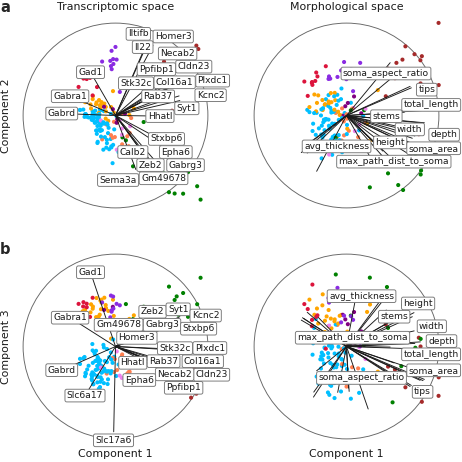

/opt/tljh/user/lib/python3.7/site-packages/numpy/lib/function_base.py:2691: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/opt/tljh/user/lib/python3.7/site-packages/numpy/lib/function_base.py:2692: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]


In [168]:
fig = plt.figure(figsize=(3.5, 3.5))

L = 3.75
scaleFactor = 3
s = 5
width = .5
col = clusterColors[selection]
labelslabels = [cn.genes[genesForRRR], #m1.morphometricsNames[feat]]
               [shortMorphLabels[e] if e in shortMorphLabels else '' for e in cn.morphometricsNames]]

for row, components in enumerate([[0,1], [0,2]]):

    Zx = X @ w[:,components]
    Zy = Y @ v[:,components]
    Zx = Zx / np.std(Zx, axis=0)
    Zy = Zy / np.std(Zy, axis=0)

    for column, (Z,F,wv,labels) in enumerate(zip([Zx,Zy], [X,Y], [w,v], labelslabels)):
    
        plt.axes([column*width+(1-2*width)/2, .5-row*width, width, width])
        plt.scatter(Z[:,0], Z[:,1], c=col, s=s, edgecolors='none')
        plt.xticks([])
        plt.yticks([])
        plt.xlim([-L,L])
        plt.ylim([-L,L])
        shownlabels = []
        Rho = np.corrcoef(np.concatenate((Z[:,:2], F), axis=1), rowvar=False)[2:,:2]
        for i in np.where(wv[:,0]!=0)[0]:
            if np.sqrt(np.sum(Rho[i,:]**2)) > .4:
                plt.plot([0, scaleFactor*Rho[i,0]], [0, scaleFactor*Rho[i,1]], 
                         linewidth=.5, color='k', zorder=1)
                dx,dy = 0,0
                if labels[i] in offsets[row][column]:
                    dx += offsets[row][column][labels[i]][0]
                    dy += offsets[row][column][labels[i]][1]
                l = plt.text(scaleFactor*Rho[i,0]*1.1 + dx, scaleFactor*Rho[i,1]*1.1 + dy, labels[i],
                     ha='center', va='center', color='k', fontsize=5, zorder=10,
                     bbox=dict(facecolor='w', edgecolor='#777777', boxstyle='round', linewidth=.5, pad=.2))
                shownlabels.append(l)

        adjustlabels(fig, shownlabels)
        circ = plt.Circle((0,0), radius=scaleFactor, color=[.4, .4, .4], fill=False, linewidth=.5, zorder=-1)
        plt.gca().add_patch(circ)

plt.gcf().text((1-2*width)/2+width/2, .978, 'Transcriptomic space', ha='center', fontsize=6, color='k')
plt.gcf().text(.5+width/2, .978, 'Morphological space', ha='center', fontsize=6, color='k')
plt.gcf().text((1-2*width)/2+width/2, .01, 'Component 1', ha='center', fontsize=6, color='k')
plt.gcf().text(.5+width/2, .01, 'Component 1', ha='center', fontsize=6, color='k')
plt.gcf().text(.002, .5+width/2, 'Component 2', va='center', fontsize=6, color='k', rotation=90)
plt.gcf().text(.002, (1-2*width)/2+width/2, 'Component 3', va='center', fontsize=6, color='k', rotation=90)

fig.text(0,  1,  'a', fontsize=8, fontweight='bold', va='top')
fig.text(0, .45,  'b', fontsize=8, fontweight='bold')
        
sns.despine(left=True, bottom=True)

plt.savefig('rrr-mor.png', dpi=300)
plt.savefig('rrr-mor.pdf', dpi=300)